In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


In [6]:
# 2. Load and Explore the Dataset

# Dataset: Mall Customers dataset

df = pd.read_csv("Mall_Customers.csv")
# View first rows
print(df.head())




   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [8]:
# Check missing values
print(df.isnull().sum())

# Encode Gender
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Drop CustomerID (irrelevant for KNN)
df.drop('CustomerID', axis=1, inplace=True)

print(df.head())



CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       0   19                  15                      39
1       0   21                  15                      81
2       1   20                  16                       6
3       1   23                  16                      77
4       1   31                  17                      40


#### ❗ IMPORTANT NOTE

The Mall Customers dataset has no target label, meaning there is no column like:

Segment

CustomerType

High/Medium/Low

➡️ So we cannot train KNN classification unless we create a target label.

We must create segmentation labels :
Low, Medium, High spending.

### Step 4: Create a Target Column (Segment)

We will segment based on Spending Score (1–100):

1–33 → Low

34–66 → Medium

67–100 → High

In [9]:
# Create segment label from Spending Score
df['Segment'] = pd.cut(
    df['Spending Score (1-100)'],
    bins=[0, 33, 66, 100],
    labels=['Low', 'Medium', 'High']
)

print(df['Segment'].value_counts())


Segment
Medium    94
High      57
Low       49
Name: count, dtype: int64


### Step 5: Split Features & Target

##### Your features will be:

Gender

Age

Annual Income

Spending Score

##### Your target will be:

Segment (Low, Medium, High)

In [12]:
X = df.drop('Segment', axis=1)
y = df['Segment']

print(X.head())
print(y.head())


   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       0   19                  15                      39
1       0   21                  15                      81
2       1   20                  16                       6
3       1   23                  16                      77
4       1   31                  17                      40
0    Medium
1      High
2       Low
3      High
4    Medium
Name: Segment, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']


### Step 6: Scaling (VERY IMPORTANT for KNN)

KNN depends on distance → must scale all numeric columns.

Use StandardScaler:

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Step 7: Train-Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


### Step 8: Fix Class Imbalance (Using SMOTE)
##### Why SMOTE?

Because:

Medium = 94

High = 57

Low = 49

KNN classification performs badly on imbalanced classes.

#### Apply SMOTE:

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())


Segment
Low       75
Medium    75
High      75
Name: count, dtype: int64


### Step 9: Find the Best K (Hyperparameter Tuning)

KNN performance depends heavily on choosing the right K.
We will test K values from 1 to 30 and choose the best one.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5)
    k_scores.append(scores.mean())

best_k = k_range[np.argmax(k_scores)]
best_k  ## <--- this will show the best K value


1

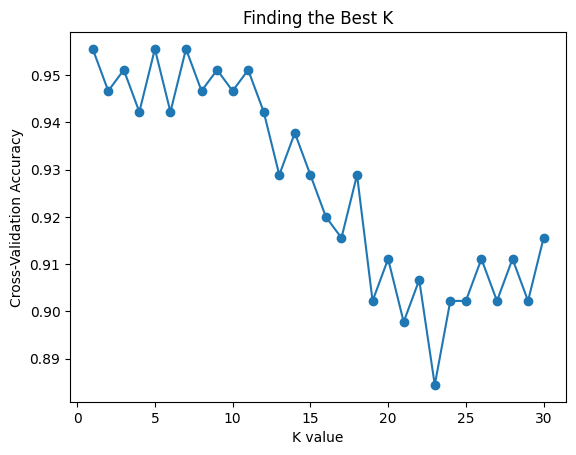

In [19]:
import matplotlib.pyplot as plt

plt.plot(k_range, k_scores, marker='o')
plt.xlabel('K value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Finding the Best K')
plt.show()


best_k = 1 means the model performs best when using 1 nearest neighbor.

This is common in small datasets with clean clusters like Mall Customers.

### Step 10: Train Final KNN Model (K=1)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_resampled, y_train_resampled)


,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### Step 11: Make Predictions

In [21]:
y_pred = knn.predict(X_test)


### Step 12: Model Evaluation

#### Accuracy

In [22]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy


0.925

#### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm


array([[11,  0,  0],
       [ 0,  9,  1],
       [ 0,  2, 17]], dtype=int64)

#### Classification Report

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00        11
         Low       0.82      0.90      0.86        10
      Medium       0.94      0.89      0.92        19

    accuracy                           0.93        40
   macro avg       0.92      0.93      0.93        40
weighted avg       0.93      0.93      0.93        40



#### ROC-AUC (One-vs-Rest for 3 classes)

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Need to binarize target for multi-class AUC
y_test_bin = label_binarize(y_test, classes=['Low','Medium','High'])
y_pred_bin = label_binarize(y_pred, classes=['Low','Medium','High'])

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
roc_auc


0.9467418546365914

### Now Final Step: Feature Importance for KNN

KNN does NOT provide coefficients like Logistic Regression.
So we estimate feature importance using Permutation Importance.

In [26]:
from sklearn.inspection import permutation_importance
import numpy as np

result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

importance_df


,Feature,Importance
3,Spending Score (1-100),0.4675
2,Annual Income (k$),0.0900
1,Age,0.0825
0,Gender,0.0100


### Feature Importance Interpretation (KNN)

| Feature            | Importance Score     | Interpretation                                                                                      |
| ------------------ | -------------------- | --------------------------------------------------------------------------------------------------- |
| **Spending Score** | **0.4675 (Highest)** | The strongest determinant of customer segment. High spenders → likely “High”, low spenders → “Low”. |
| **Annual Income**  | 0.0900               | Higher income mildly influences a customer to fall into Medium/High segments.                       |
| **Age**            | 0.0825               | Younger customers tend to spend more; older customers cluster around Medium or Low.                 |
| **Gender**         | 0.0100 (Very low)    | Gender almost does NOT affect spending. Very common in mall segmentation datasets.                  |
